In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time



project_root =  os.path.join(os.getcwd(), '..', 'src')
sys.path.append(project_root)

from synthetic_lightcurves import *
from reverberation_mapper import *
import lightcurve_processing as lp
import fileIO_processing as fp

# Generating Synthetic Optical and IR lightcurves

## Simulating a Damped Random Walk

In [3]:
t, m = generate_drw()
t = (t*u.day).to(u.year)

Text(0, 0.5, 'magnitude')

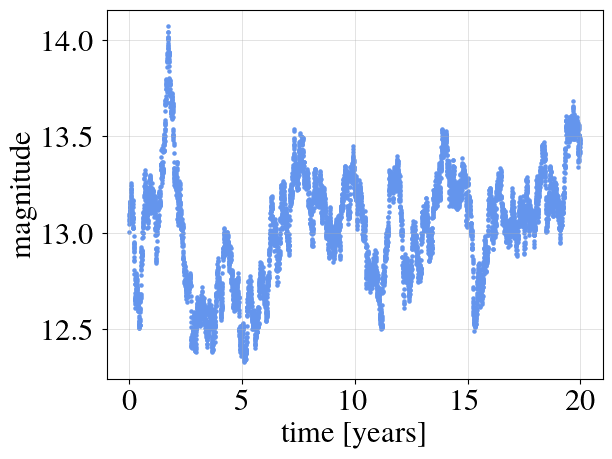

In [4]:
fig, ax = plt.subplots()

ax.scatter(t, m+13, s=5, c='cornflowerblue')
ax.grid(lw=0.5, alpha=0.5)

ax.set_xlabel('time [years]')
ax.set_ylabel('magnitude')

## Simulating both optical and IR lightcurves

In [5]:
mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data 

w1 = fp.process_wise('10223-3701', mwv, band=1)
w2 = fp.process_wise('10223-3701', mwv, band=2)

wise_times = w1['time'].to_value('decimalyear')

In [73]:
lag=(0.5*u.year).to(u.day).value

synth_opt_lc_full, synth_w1_full, synth_w2_full = generate_sim_lc(lag=lag)

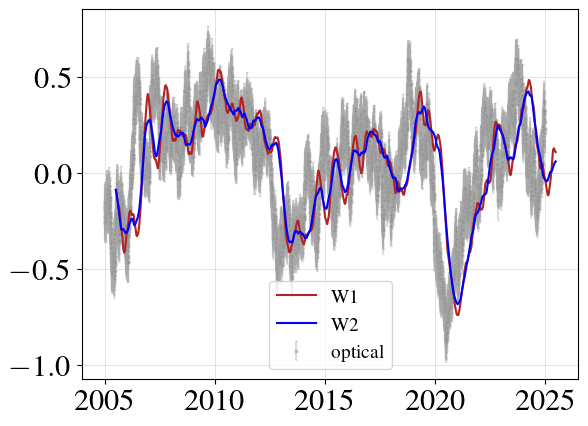

In [74]:
fig, ax = plt.subplots()

ax.errorbar(synth_opt_lc_full['time'].to_value('decimalyear'), synth_opt_lc_full['mag'], yerr=synth_opt_lc_full['mag_err'],
            ls='None', marker='o', ms=2,
            mfc='grey', mec='darkgrey', c='darkgrey', capsize=1,
            alpha=0.4, zorder=-1, label='optical')

ax.plot(synth_w1_full['time'].to_value('decimalyear'), synth_w1_full['mag'],
            c='firebrick', alpha=1, label='W1')

ax.plot(synth_w2_full['time'].to_value('decimalyear'), synth_w2_full['mag'],
            c='blue', alpha=1, label='W2')

# ax.errorbar(synth_w2_full['time'].to_value('decimalyear'), synth_w2_full['mag'], yerr=synth_w2_full['mag_err'],
#              ms=5,
#             mfc='cornflowerblue', mec='blue', c='blue', capsize=1,
#             alpha=0.8, label='Synth W2')
ax.legend(fontsize=14)
ax.grid(lw=0.5, alpha=0.5)

## Simulating the cadences of WISE and CRTS/ASAS-SN/ZTF

this function simulates the cadences of the surveys used in this project, multiplies the W1 & W2 lightcurves with an amplitude between 2-8 as is seen in the data, and adds gaussian noise to the synthetic WISE observations

In [75]:
# can pass the full lightcurves and get lightcurves that have cadences that match the surveys used
synth_opt_lc, synth_w1, synth_w2 = generate_noisy_lc(synth_opt_lc_full=synth_opt_lc_full,
                                                    synth_w1_full=synth_w1_full,
                                                    synth_w2_full=synth_w2_full)

# can also enter the 'lag' argument only and get new light curves like so:
# synth_opt_lc, synth_w1, synth_w2 = generate_noisy_lc(lag=lag)

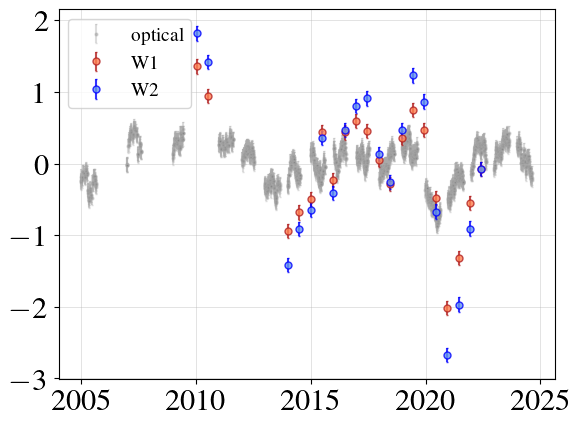

In [76]:
fig, ax = plt.subplots()

ax.errorbar(synth_opt_lc['time'].to_value('decimalyear'), synth_opt_lc['mag'], yerr=synth_opt_lc['mag_err'],
            ls='None', marker='o', ms=2,
            mfc='grey', mec='darkgrey', c='darkgrey', capsize=1,
            alpha=0.4, zorder=-1, label='optical')

ax.errorbar(synth_w1['time'].to_value('decimalyear'), synth_w1['mag'], yerr=synth_w1['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='coral', mec='firebrick', c='firebrick', capsize=1,
            alpha=0.8, label='W1')

ax.errorbar(synth_w2['time'].to_value('decimalyear'), synth_w2['mag'], yerr=synth_w2['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='cornflowerblue', mec='blue', c='blue', capsize=1,
            alpha=0.8, label='W2')
ax.legend(fontsize=14)
ax.grid(lw=0.5, alpha=0.5)

## try to recover lags using the FixedWidthModel

In [77]:
fwm = FixedWidthModel(plateifu=None, optical_data=synth_opt_lc, verbose=0, optical_data_mode='raw')

minimizer_args = dict(ranges=((-2, 2, 0.01),), weighted=1)
model1 = fwm.minimize_chisq(IR_data=synth_w1, **minimizer_args)
w1_results = np.array(fwm.results_log.copy())

model2 = fwm.minimize_chisq(IR_data=synth_w2, **minimizer_args)
w2_results = np.array(fwm.results_log.copy())

In [78]:
convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)
predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], IR_data=synth_w1)

convw2, t_convw2, err_convw2 = fwm.convolve(model2[0], 0.5)
predw2, err_predw2, t_predw2, a2, c2, _ = fwm.predict_mags([model2[0]], IR_data=synth_w2)

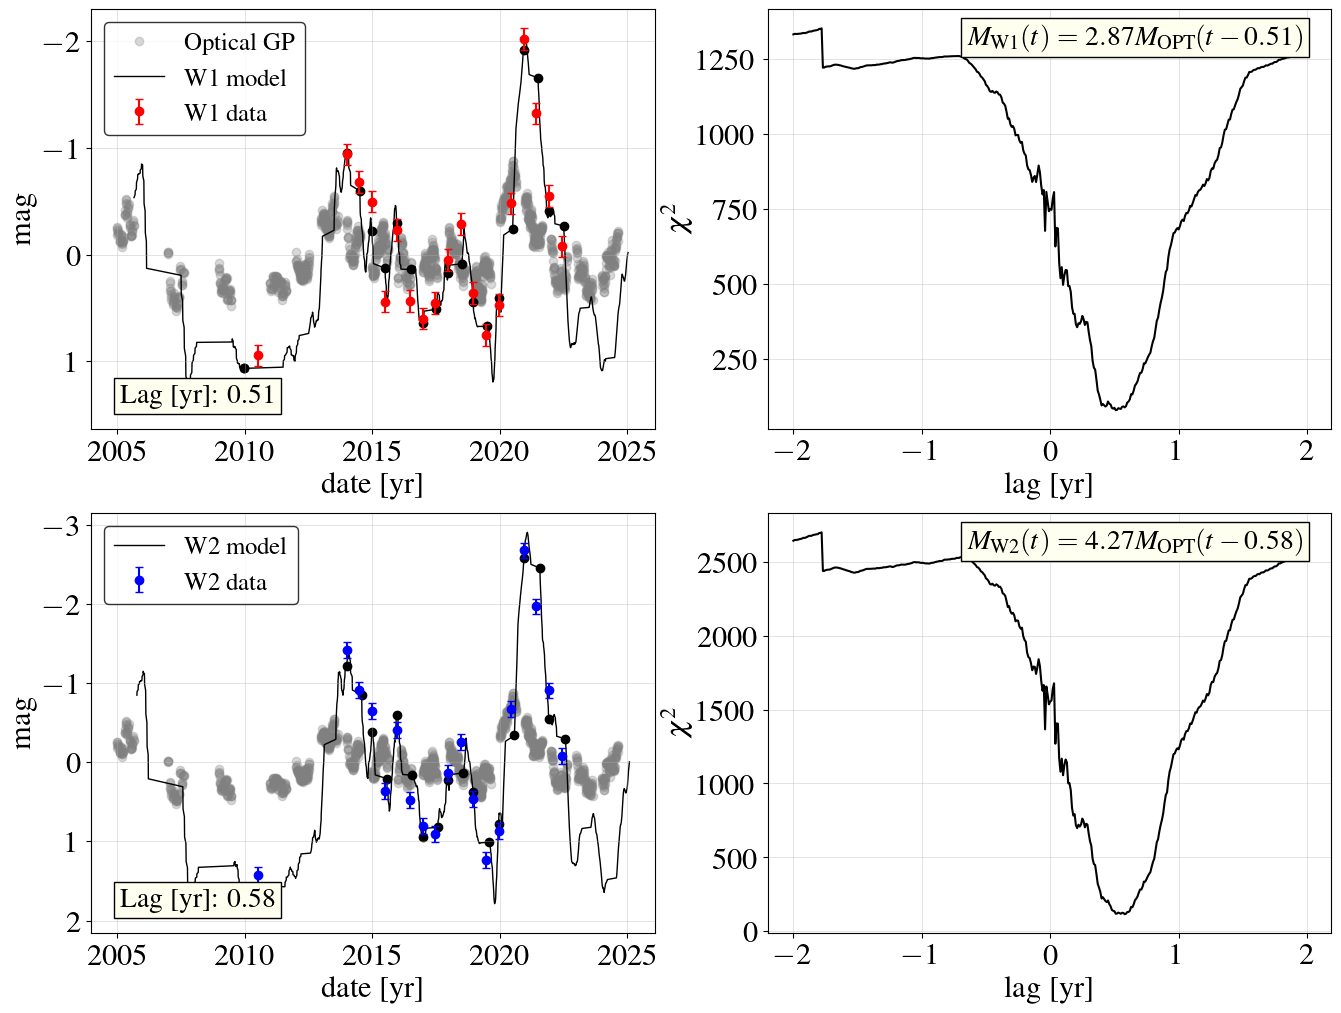

In [79]:
# Create a 2x2 grid of subplots with a large figure size (16x12 inches)
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)

# Top-left plot: Optical GP light curve and W1 model comparison
ax[0, 0].plot(
    fwm.t_opt,  # Convert time to decimal years for x-axis
    fwm.m_opt,                          # Magnitudes from optical Gaussian Process
    c='grey', lw=2, marker='o', ls='None', label='Optical GP',
    alpha=0.3, zorder=-1  # Grey dashed line for optical GP data
)

# Plot W1 model light curve: convolved and scaled model shifted by lag
ax[0, 0].plot(
    t_convw1 + model1[0],                           # Shift time by lag (model1[0])
    model1[1] * convw1 + model1[2],                 # Scale and offset convolved model flux
    c='k', lw=1, label='W1 model', zorder=-1       # Black line, behind other plots
)

# Scatter predicted W1 magnitudes on the same plot
ax[0, 0].scatter(t_predw1, predw1, c='k')

# Plot actual W1 data points with error bars (red circles)
ax[0, 0].errorbar(
    synth_w1['time'].to_value('decimalyear'),         # W1 observation times in decimal years
    synth_w1['mag'],                                  # W1 magnitudes
    yerr=synth_w1['mag_err'],                         # Errors on magnitudes
    c='red', capsize=3, linestyle='none', marker='o', label='W1 data'
)

# Add a text box showing the lag value in years on the bottom left
ax[0, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model1[0], 3)),  # Lag rounded to 3 decimals
    ha='left', va='bottom', fontsize=20,
    transform=ax[0, 0].transAxes,                          # Coordinates relative to axes
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), # Ivory background with black border
    zorder=5                                              # Draw on top
)

# Invert y-axis so that magnitude decreases upward
ax[0, 0].invert_yaxis()

# Add legend with black edge and larger font
ax[0, 0].legend(edgecolor='k', fontsize=18)

# Label axes
ax[0, 0].set_ylabel('mag')
ax[0, 0].set_xlabel('date [yr]')

# Top-right plot: Chi-squared vs lag for W1 results
ax[0, 1].set_xlabel('lag [yr]')
ax[0, 1].set_ylabel(r'$\chi^2$')

# Plot chi-squared values from W1 fitting results
ax[0, 1].plot(w1_results[:, 0], w1_results[:, 3], c='k')

# Add text showing the W1 model equation and fitted parameters on top right
ax[0, 1].text(
    0.95, 0.9,
    r'$M_{\rm W1}(t)=' + str(np.round(model1[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model1[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[0, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Bottom-left plot: Optical GP and W2 model comparison (similar to top-left)
ax[1, 0].plot(
    fwm.t_opt,
    fwm.m_opt,
    c='grey', lw=2, marker='o', ls='None',
    alpha=0.3, zorder=-1 
)
ax[1, 0].plot(
    t_convw2 + model2[0],
    model2[1] * convw2 + model2[2],
    c='k', lw=1, label='W2 model', zorder=-1
)
ax[1, 0].scatter(t_predw2, predw2, c='k')
ax[1, 0].errorbar(
    synth_w2['time'].to_value('decimalyear'),
    synth_w2['mag'],
    yerr=synth_w2['mag_err'],
    c='blue', capsize=3, linestyle='none', marker='o', label='W2 data'
)

# Add lag text box on bottom left
ax[1, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model2[0], 3)),
    ha='left', va='bottom', fontsize=20,
    transform=ax[1, 0].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Invert y-axis for magnitudes
ax[1, 0].invert_yaxis()

# Legend and axis labels
ax[1, 0].legend(edgecolor='k', fontsize=18)
ax[1, 0].set_ylabel('mag')
ax[1, 0].set_xlabel('date [yr]')

# Bottom-right plot: Chi-squared vs lag for W2 results
ax[1, 1].set_ylabel(r'$\chi^2$')
ax[1, 1].set_xlabel('lag [yr]')
ax[1, 1].plot(w2_results[:, 0], w2_results[:, 3], c='k')

# Add W2 model equation text box
ax[1, 1].text(
    0.95, 0.9,
    r'$M_{\rm W2}(t)=' + str(np.round(model2[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model2[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[1, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Add grid lines with light opacity and thin lines to all four subplots
for i in range(2):
    for j in range(2):
        ax[i, j].grid(lw=0.5, alpha=0.5)

# Make the x-axis of the top-left and bottom-left plots share the same scale
ax[0, 0].sharex(ax[1, 0])


## Monte-Carlo simulation to recover lags

In [17]:
from tqdm import tqdm
N=1000
best_fit_params, best_fit_lag_err = [], []
synth_lcs = []

#can choose to do this for a bunch of different lags and compare error in lag vs. predicted lag as well
lags=[0.25]*N#np.random.uniform(0.01, 2, size=N) # in years

for i in tqdm(range(N)):
    lag=(lags[i]*u.year).to(u.day).value

    synth_opt_lc, synth_w1, synth_w2 = generate_noisy_lc(lag=lag)
    
    fwm = FixedWidthModel(plateifu=None, optical_data=synth_opt_lc, verbose=0)

    minimizer_args = dict(ranges=((-2, 2, 0.01),), weighted=0)
    model1 = fwm.minimize_chisq(IR_data=synth_w1, **minimizer_args)
    w1_results = np.array(fwm.results_log.copy())
    best_fit_lag_err.append(model1[0]-lags[i])
    best_fit_params.append(model1)
    convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)
    predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], IR_data=synth_w1)

100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


In [18]:
best_fit_lags = np.array(best_fit_params)[:,0]

median = np.median(best_fit_lag_err)
lower = np.percentile(best_fit_lag_err, 16)
upper = np.percentile(best_fit_lag_err, 84)

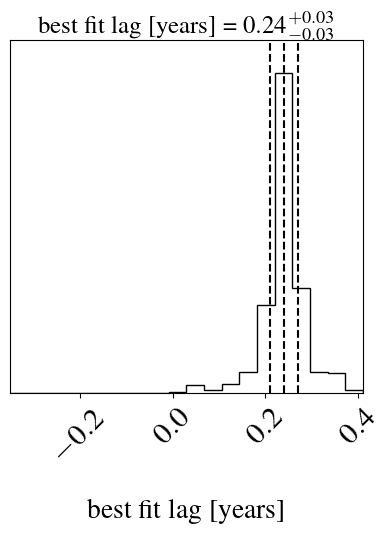

In [19]:
import corner

fig = plt.figure(figsize=(6, 6)) 
fig = corner.corner(np.array(best_fit_lags).reshape(-1, 1),
            fig=fig,
            labels=["best fit lag [years]"],
            show_titles=True,
            title_fmt=".2f",
            quantiles=[0.16, 0.5, 0.84],
            title_kwargs={"fontsize": 18},
            label_kwargs={"fontsize": 20},
            color="k")

## Monte-Carlo simulations over a uniform set of lags to quantify error between lag and lag fit

In [23]:
N=10000
best_fit_params, best_fit_lag_err = [], []
synth_lcs = []

#can choose to do this for a bunch of different lags and compare error in lag vs. predicted lag as well
lags=np.random.uniform(0.01, 2, size=N) # in years

for i in tqdm(range(N)):
    lag=(lags[i]*u.year).to(u.day).value

    synth_opt_lc, synth_w1, synth_w2 = generate_noisy_lc(lag=lag)
    
    fwm = FixedWidthModel(plateifu=None, optical_data=synth_opt_lc, verbose=0)

    minimizer_args = dict(ranges=((-2, 2, 0.01),), weighted=0)
    model1 = fwm.minimize_chisq(IR_data=synth_w1, **minimizer_args)
    w1_results = np.array(fwm.results_log.copy())
    best_fit_lag_err.append(model1[0]-lags[i])
    best_fit_params.append(model1)
    convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)
    predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], IR_data=synth_w1)

100%|██████████| 10000/10000 [28:33<00:00,  5.84it/s]


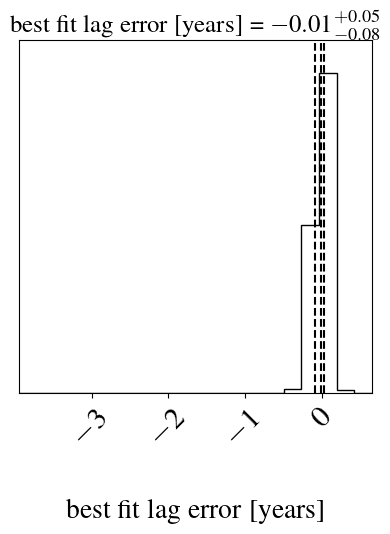

In [24]:
fig = plt.figure(figsize=(6, 6)) 
fig = corner.corner(np.array(best_fit_lag_err).reshape(-1, 1),
            fig=fig,
            labels=["best fit lag error [years]"],
            show_titles=True,
            title_fmt=".2f",
            quantiles=[0.16, 0.5, 0.84],
            title_kwargs={"fontsize": 18},
            label_kwargs={"fontsize": 20},
            color="k")

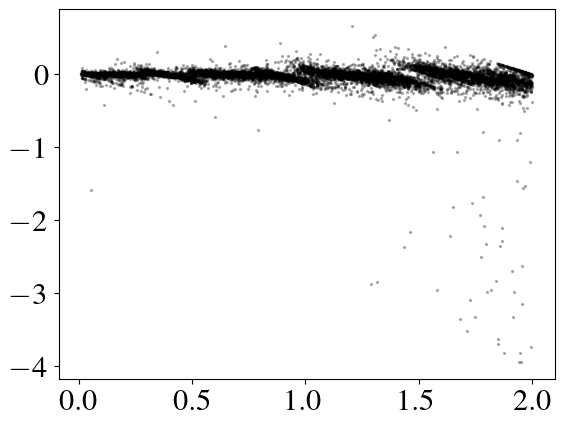

In [31]:
plt.scatter(lags, best_fit_lag_err, alpha=0.25, c='k', s=2)